In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pulsedb-dataset-pytorch-tensors/X_train.pt
/kaggle/input/pulsedb-dataset-pytorch-tensors/X_test.pt
/kaggle/input/pulsedb-dataset-pytorch-tensors/Y_test.pt
/kaggle/input/pulsedb-dataset-pytorch-tensors/Y_train.pt


In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [108]:
X_train = torch.load('/kaggle/input/pulsedb-dataset-pytorch-tensors/X_train.pt')
Y_train = torch.load('/kaggle/input/pulsedb-dataset-pytorch-tensors/Y_train.pt')
X_test = torch.load('/kaggle/input/pulsedb-dataset-pytorch-tensors/X_test.pt')
Y_test = torch.load('/kaggle/input/pulsedb-dataset-pytorch-tensors/Y_test.pt')

X_train[:, :1250] = 2 * X_train[:, :1250] - 1
X_test[:, :1250] = 2 * X_test[:, :1250] - 1

/tmp/ipykernel_36/748861822.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train = torch.load('/kaggle/input/pulsedb-dataset-pytorch-tensors/X_train.pt')
/tmp/ipykern

## Dataset

In [121]:
batch_size = 512

In [122]:
# Dataset and DataLoader
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Attention3 Ways

In [123]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [124]:
import torch
import torch.nn as nn
import math

class TransformerModelConcatenating(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_additional_features, nhead=8, dropout=0.1):
        super(TransformerModelConcatenating, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, hidden_size*4, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size + num_additional_features, output_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, additional_features):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(src.shape[2])
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        
        # Repeat additional features for each time step
        additional_features_repeated = additional_features.unsqueeze(1).repeat(1, output.size(1), 1)
        
        # Concatenate Transformer output with additional features
        combined = torch.cat((output, additional_features_repeated), dim=2)
        
        output = self.decoder(combined)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [125]:
# # Hyperparameters
# input_size = 1
# hidden_size = 64
# output_size = 1
# num_layers = 4
# batch_size = 64
# num_epochs = 100
# learning_rate = 0.001
# num_additional_features = 5

# # Model, Loss, Optimizer
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = TransformerModelConcatenating(input_size, hidden_size, output_size, num_layers, num_additional_features).to(device)

# # Multi-GPU support
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)

In [126]:
# class TransformerModelInitialInput(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers, num_additional_features, nhead=8, dropout=0.1):
#         super(TransformerModelInitialInput, self).__init__()
#         self.model_type = 'Transformer'
#         self.src_mask = None
#         self.pos_encoder = PositionalEncoding(hidden_size)
#         encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, hidden_size*4, dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
#         self.encoder = nn.Linear(input_size, hidden_size)
#         self.decoder = nn.Linear(hidden_size, output_size)
#         self.additional_features_encoder = nn.Linear(num_additional_features, hidden_size)
#         self.init_weights()

#     def init_weights(self):
#         initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
#         self.decoder.weight.data.uniform_(-initrange, initrange)
#         self.additional_features_encoder.weight.data.uniform_(-initrange, initrange)

#     def forward(self, src, additional_features):
#         # Ensure that the source mask reflects the new sequence length (1251)
#         if self.src_mask is None or self.src_mask.size(0) != len(src) + 1:
#             device = src.device
#             mask = self._generate_square_subsequent_mask(len(src)).to(device)
#             self.src_mask = mask

#         # Encode the original input
#         src = self.encoder(src) * math.sqrt(src.shape[2])
#         src = self.pos_encoder(src)

#         # Encode additional features and concatenate to the src
#         additional_input = self.additional_features_encoder(additional_features).unsqueeze(1)
#         src = torch.cat([additional_input, src], dim=1)  # Concatenate additional features to the sequence

#         # Pass the concatenated sequence through the Transformer encoder
#         output = self.transformer_encoder(src, self.src_mask)

#         # Ignore the output corresponding to the additional input and focus on the original sequence
#         output = output[:, 1:, :]  # Remove the additional input's output

#         # Decode the final output
#         output = self.decoder(output)

#         return output


#     def _generate_square_subsequent_mask(self, sz):
#         mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         return mask

In [127]:
# # Hyperparameters
# input_size = 1
# hidden_size = 20
# output_size = 1
# num_layers = 6
# batch_size = 128
# num_epochs = 100
# learning_rate = 0.01
# num_additional_features = 5

# # Model, Loss, Optimizer
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = TransformerModelInitialInput(input_size, hidden_size, output_size, num_layers, num_additional_features, nhead=5).to(device)

# # Multi-GPU support
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)

In [128]:
class TransformerModelDualInput(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_additional_features, nhead=8, dropout=0.1):
        super(TransformerModelDualInput, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, hidden_size*4, dropout, activation=nn.Tanh())
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, output_size)
        )
        self.fc_additional = nn.Sequential(
            nn.Linear(num_additional_features, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
        )
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        for layer in self.encoder:
            if isinstance(layer, nn.Linear):
                layer.weight.data.uniform_(-initrange, initrange)
                layer.bias.data.zero_()

        for layer in self.decoder:
            if isinstance(layer, nn.Linear):
                layer.weight.data.uniform_(-initrange, initrange)
                layer.bias.data.zero_()


    def forward(self, src, additional_features):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(src.shape[2])
        src = self.pos_encoder(src)
        transformer_out = self.transformer_encoder(src, self.src_mask)
        
        additional_out = self.fc_additional(additional_features).unsqueeze(1).repeat(1, transformer_out.size(1), 1)
        
        combined = torch.cat((transformer_out, additional_out), dim=2)
        output = self.decoder(combined)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [129]:
# Hyperparameters
input_size = 1
hidden_size = 4
output_size = 1
num_layers = 6
batch_size = 512
num_epochs = 100
learning_rate = 0.1
num_additional_features = 5

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModelDualInput(input_size, hidden_size, output_size, num_layers, num_additional_features, nhead=4).to(device)

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

## Train

In [130]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [131]:
def plot_random_sample(model, X_test, Y_test, device, epoch, batch=None):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        random_idx = random.randint(0, len(X_test) - 1)  # Random sample index
        sample_input = X_test[random_idx, :1250].unsqueeze(0).unsqueeze(2).to(device)  # Shape [1, 1250, 1]
        sample_input_f = X_test[random_idx, 1250:].reshape(1, 5).to(device)
        sample_output = model(sample_input, sample_input_f)  # Get the model's prediction

        # Plot actual vs predicted ABP
        plt.figure(figsize=(10, 5))
        plt.plot(Y_test[random_idx].cpu().numpy(), label='Actual', color='red')
        plt.plot(sample_output.cpu().squeeze().detach().numpy(), label='Predicted', color='blue')
        if batch:
            plt.title(f'Epoch {epoch + 1} | Batch {batch+1}: Random Sample Prediction')
        else:
            plt.title(f'Epoch {epoch + 1}: Random Sample Prediction')
        plt.xlabel('Time')
        plt.ylabel('ABP')
        plt.legend()
        plt.show()
    model.train()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/910 [00:00<?, ?it/s]

torch.Size([512, 1255])
7521.69091796875


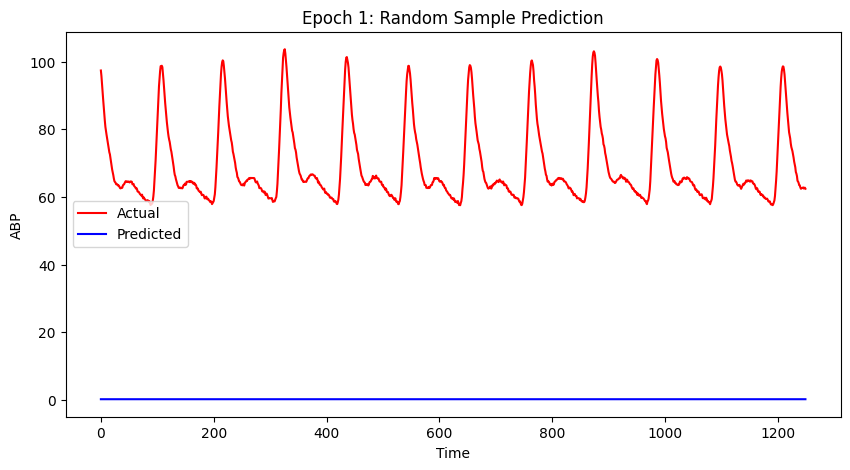

torch.Size([512, 1255])
773.3869018554688


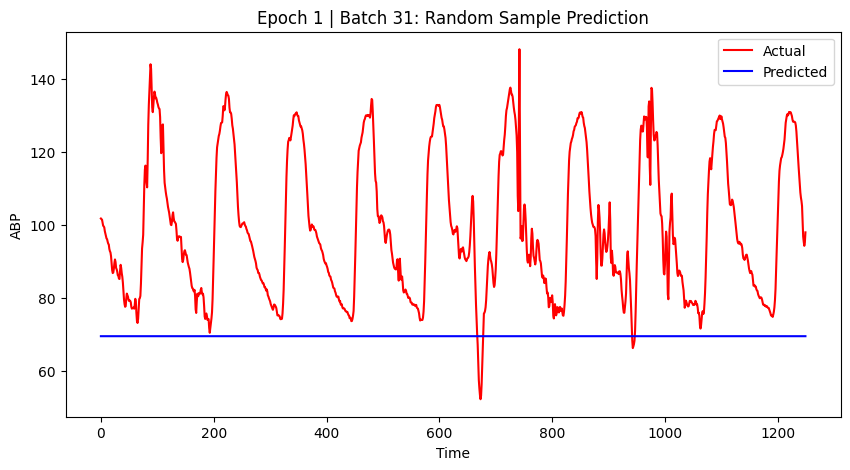

torch.Size([512, 1255])
701.8499145507812


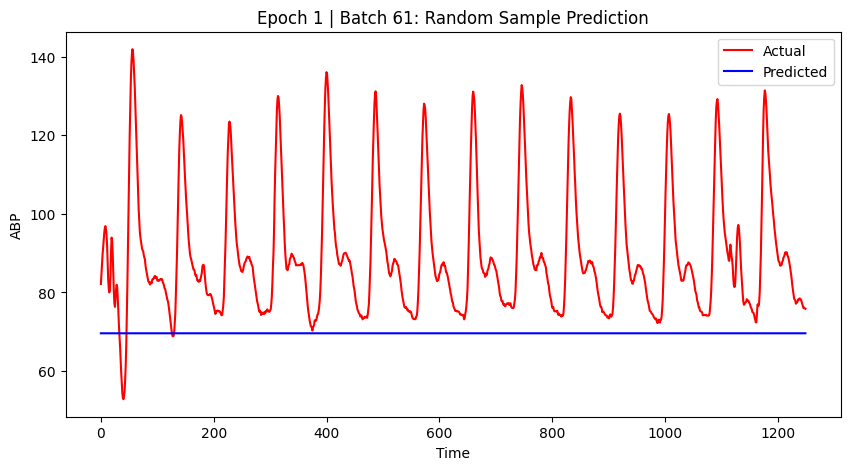

torch.Size([512, 1255])
725.0454711914062


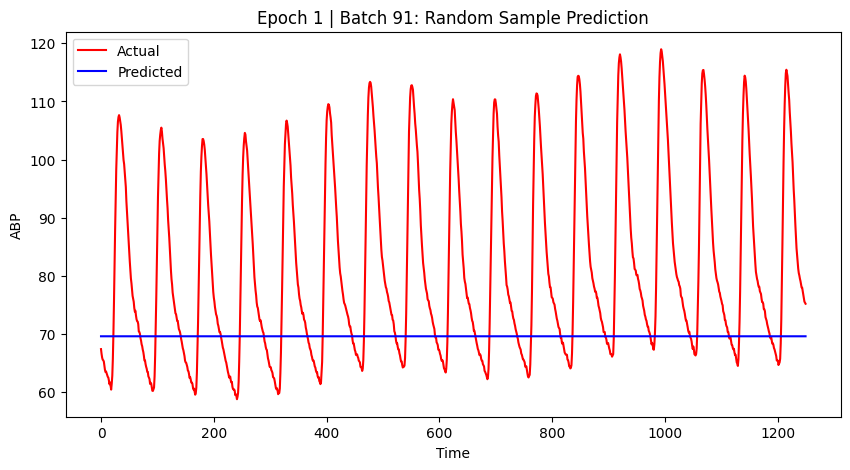

torch.Size([512, 1255])
702.3272094726562


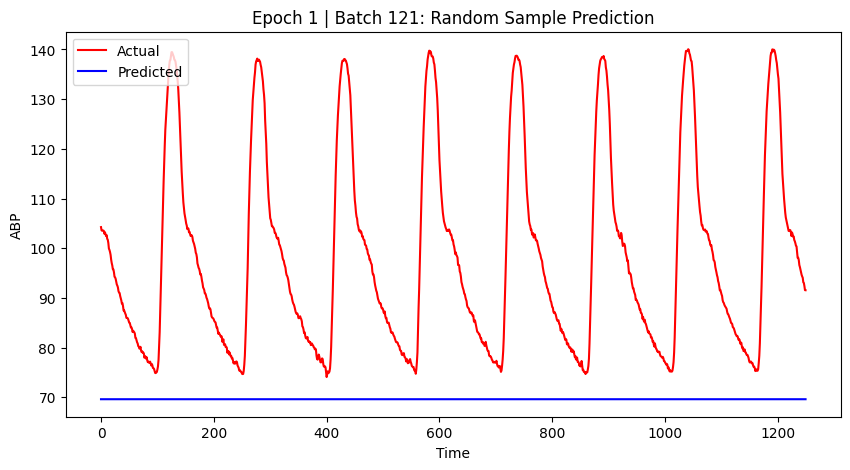

torch.Size([512, 1255])
722.6221923828125


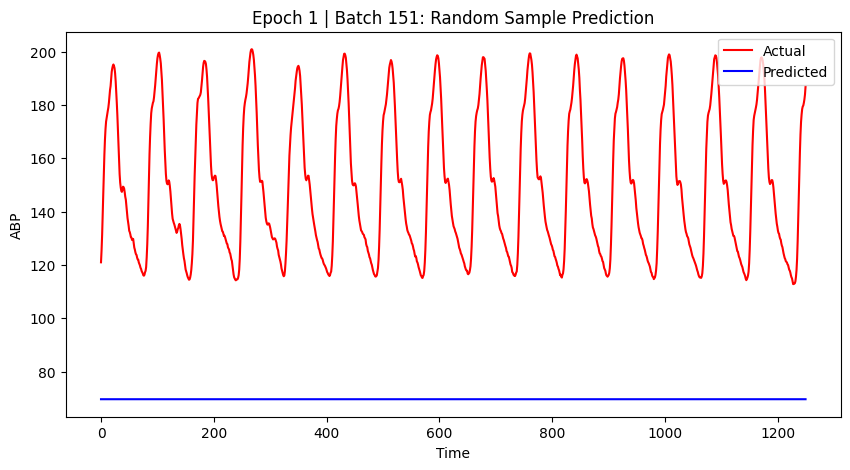

torch.Size([512, 1255])
695.1967163085938


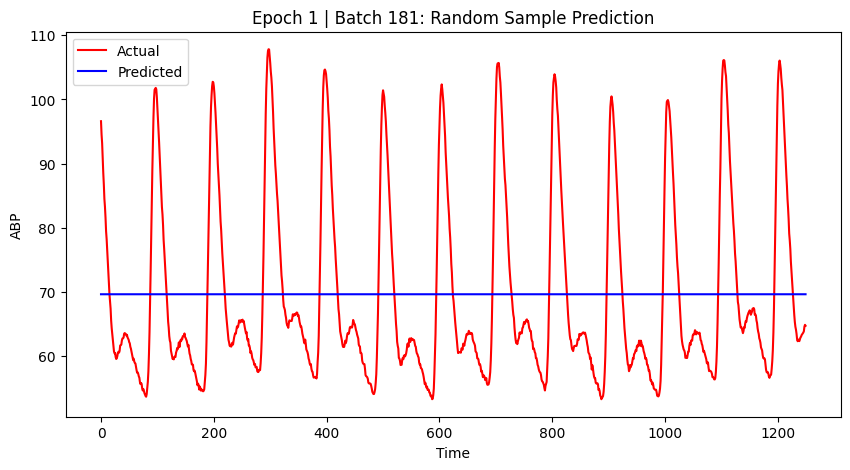

torch.Size([512, 1255])
775.45703125


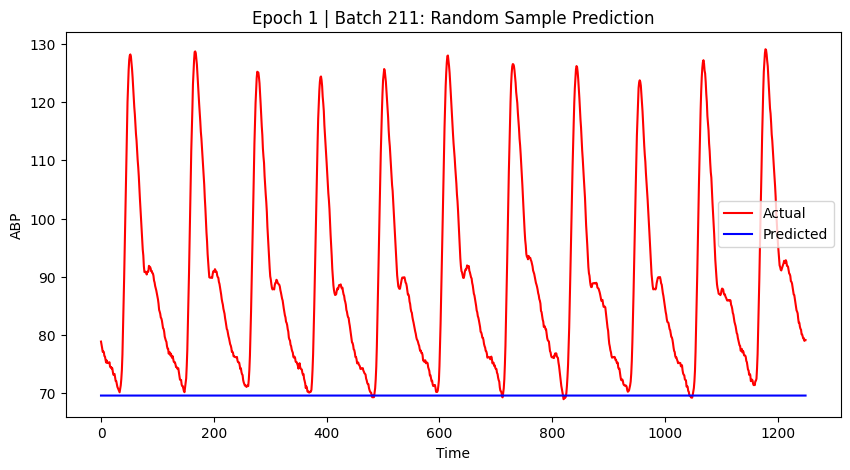

torch.Size([512, 1255])
686.55078125


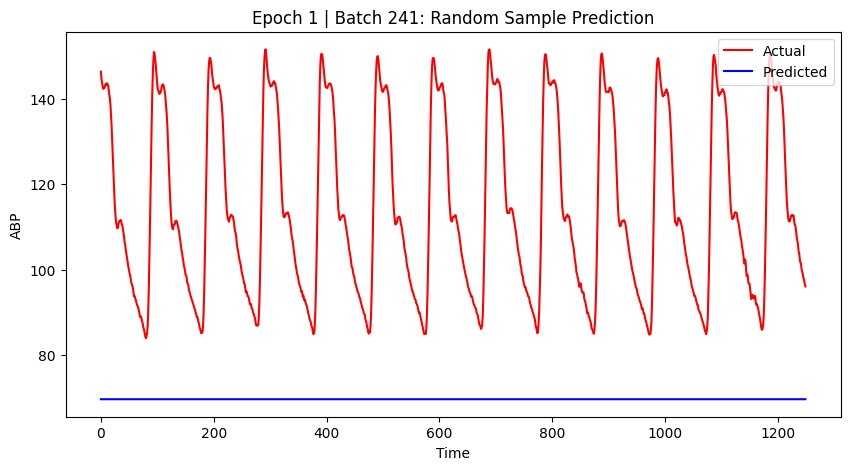

torch.Size([512, 1255])
760.6798706054688


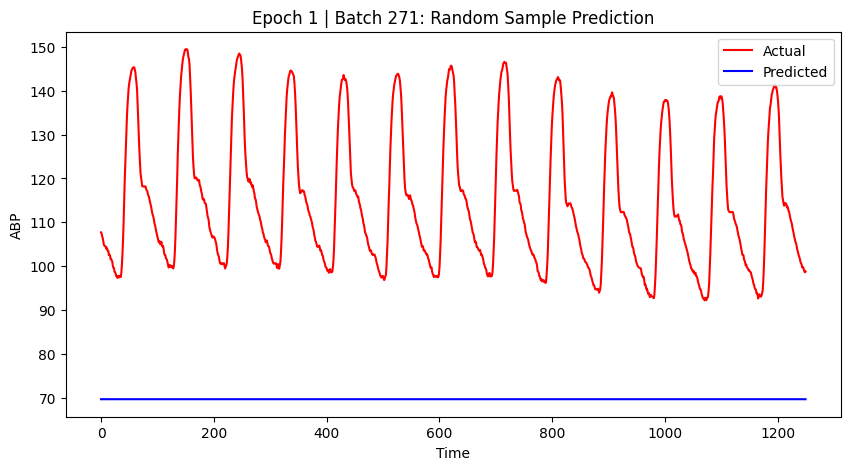

torch.Size([512, 1255])
698.2431030273438


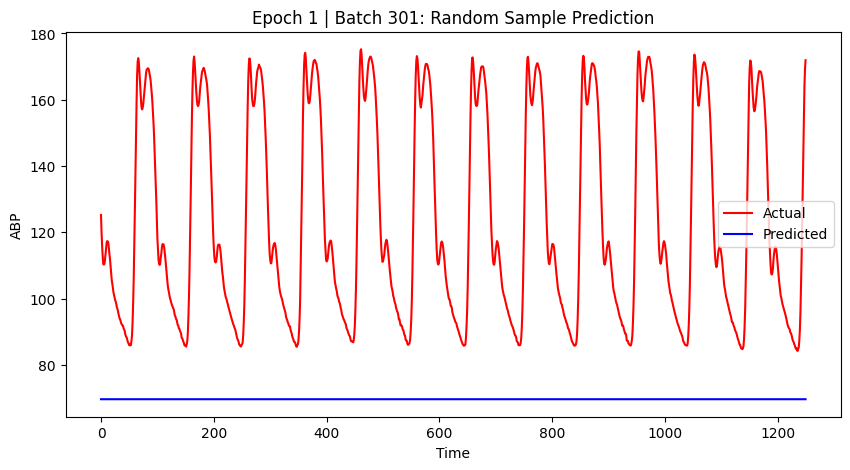

KeyboardInterrupt: 

In [132]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        time_series_data = data[:, :1250].unsqueeze(2).to(device)  # Shape: [batch, 1250, 1]
        additional_features = data[:, 1250:].to(device)  # Shape: [batch, 5]
        target = target.to(device)

        optimizer.zero_grad()
        output = model(time_series_data, additional_features)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        
        scheduler.step(loss.item())

        if batch_idx % 30 == 0:
            print(data.shape)
            print(loss.item())
            plot_random_sample(model, X_test, Y_test, device, epoch, batch_idx)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            time_series_data = data[:, :1250].unsqueeze(2).to(device)
            additional_features = data[:, 1250:].to(device)
            target = target.to(device)
            output = model(time_series_data, additional_features)
            val_loss += criterion(output.squeeze(), target).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

print("Training completed.")